In [1]:
import subprocess
from subprocess import Popen, PIPE
import glob
import numpy as np
from numpy.linalg import norm
import scipy.signal as signal
import scipy.io.wavfile as wav
import numpy as np
import sympy
import scipy
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.signal import find_peaks
import numpy as np
from leaf_gp.leaf_gp_utils import LeafGP
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from statistics import NormalDist
import statsmodels.api as sm
from scipy.stats import norm as snorm

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Various constants used in the model.

In [2]:
global fs;
fs = 16000;
global dt;
dt = 1 / fs;
global ioi_ms;
ioi_ms = 8;
global min_ns;
min_ns = int(np.floor(2 / (dt*1e3)));
global max_ns;
max_ns = int(np.floor(ioi_ms * 2 / (dt*1e3)));
global use_bp;
use_bp = 0;
global xcorr_non_refl_ms;
xcorr_non_refl_ms = 0.5;
global max_h_score;
max_h_score = 10;
global hist_threshold;
hist_threshold = 0.1;
global hist_edges;
hist_edges = int(np.floor(ioi_ms + 1));

Model code in Python.

In [3]:
def xcorr(x):
    corr = signal.correlate(x, x, mode="full")
    corr = corr / np.max(corr)
    lags = signal.correlation_lags(len(x), len(x), mode="full")
    return corr, lags

def calc_xcorr(yf, delay, xcorr_delta):

    global dt;
    global mpp;
    global xcorr_non_refl_ms;

    corr_num_s = delay;

    corr_bins = np.zeros((int(corr_num_s), int(delay)));

    num_s = int(delay);
        
    autocorr, lags = xcorr(yf[0:num_s-1]);
        
    autocorr = autocorr[lags >= 0];
    
    corr_bins[0:num_s-1, int(delay)-1] = autocorr;
    corr_vals = corr_bins[0:num_s-1, int(delay)-1];

    corr_vals[0:round(xcorr_non_refl_ms / (dt * 1e3))] = 0;

    if xcorr_delta:
        corr_vals = delta_signal(corr_vals);
    else:
        corr_vals = abs(corr_vals);
    
    p_locs, p_proms = find_peaks(corr_vals, prominence=mpp, width=[0, np.floor(2 / (dt * 1e3))]);

    return p_locs, p_proms['prominences']

def calc_xcorrs(yf, min_delay, max_delay, num_ints, xcorr_delta):

    delays = np.round(np.linspace(min_delay, max_delay, num_ints));
            
    p_locs = [];
    p_proms = [];

    plot_num = 1;
    for i in range(len(delays)):
        delay = delays[i];
        (locs, proms) = calc_xcorr(yf, delay, xcorr_delta);
        
        if len(locs) > 0:
            p_locs = np.concatenate((p_locs, locs));
        if len(proms) > 0:
            p_proms = np.concatenate((p_proms, proms));

    hist_values = weighted_hist(p_locs, p_proms);

    return hist_values

def weighted_hist(p_locs, p_proms):

    global ioi_ms;
    global dt;
    global hist_edges;

    edges = np.linspace(1, np.floor(ioi_ms / (dt * 1e3)), hist_edges);
    values, bin_edges = np.histogram(p_locs, bins=edges)
    wgts = np.zeros(values.shape);
    for i in range(len(values)):
        locs = (p_locs >= edges[i]) & (p_locs < edges[i+1]);
        if len(locs) > 0:
            wgts[i] = np.sum(p_proms[locs]);

    values = wgts;

    if np.max(values) > 0:
        values = values / np.max(values);

    return values

def delta_signal(signal):
    
    global delta_neigh;
    
    delta_s = np.concatenate((signal, [0 for i in range(delta_neigh)]), axis=0) - \
                np.concatenate(([0 for i in range(delta_neigh)], signal), axis=0);
    delta_s = abs(delta_s[:-delta_neigh]);
    return delta_s

def load_wav(fname):
    
    global fs;
        
    fs_s, signal = wav.read(fname)
            
    signal = signal.astype(float) / 32767.0
            
    p, q = sympy.fraction(sympy.nsimplify(fs / fs_s))
    ir = scipy.signal.resample_poly(signal, p, q);
    
    signal = signal / np.sqrt(np.mean(signal * signal));
    signal = signal / np.max(np.abs(signal));
    
    signal = signal[np.argwhere(signal >= 5e-2)[0][0]:np.argwhere(signal >= 5e-3)[-1][0]]
    
    return signal

global delta_neigh;
global xcorr_int;
global mpp;

def run_model_py(input_dir, delta_, xcorr_int_, mpp_):
    
    global delta_neigh;
    global xcorr_int;
    global mpp;
    
    delta_neigh = delta_;
    xcorr_int = xcorr_int_;
    mpp = mpp_;
    
    fc_low = 200;
    fc_hi = 6500;
    fir_ord = 128;
    
    global use_bp;
    
    bp_filter = scipy.signal.firwin(fir_ord, (fc_low/(fs/2), fc_hi/(fs/2)), \
                        window = ("chebwin", fir_ord+1), pass_zero = 'bandpass')
    
    for filepath in glob.iglob('''%s/file_*.wav''' % (input_dir)):
        
        yf = load_wav(filepath);
        
        if use_bp and (fc_hi < (fs/2)):
            yf = scipy.signal.lfilter(bp_filter, 1, yf);
                
        xcorr_hist = calc_xcorrs(yf, min_ns, max_ns, xcorr_int, True);
        
        np.savetxt(filepath.replace('.wav', '_predicted.txt'), xcorr_hist, fmt='%.2f', newline=' ', delimiter='')

Another version of the model is implemented in MATLAB and run outside of this workbook.

In [4]:
def run_model():
    cmd = subprocess.Popen(["/Applications/MATLAB_R2022b.app/bin/matlab", \
                            '''-nodesktop -nojvm -nosplash -r "run('model.m'); exit;"'''], \
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = cmd.communicate()
    return "\n".join(str(out).split('\\n')[10:-1])

The similarity score is a weighted combination of two partial scores:
- a measure which is taking into account the histogram bin heights. This calculated as a truncated cosine similarity measure
- a measure which is not taking into account the histogram bin heights, only which bins are non-zero. This a further weighted combination of two partial scores:
  - a measure of incompleteness
  - a measure of false positiveness

In [5]:
def test_xcorr_hist(rir_hist, xcorr_hist):

    global max_h_score;
    max_h_score = 10;
    global hist_threshold;
    hist_threshold = 0.1;

    rir_hist[rir_hist < hist_threshold] = 0;
    xcorr_hist[xcorr_hist < hist_threshold] = 0;

    e = np.sum(rir_hist > 0);
    d = np.sum(xcorr_hist > 0);
    s = np.sum((rir_hist > 0) | (xcorr_hist > 0));
    c = np.sum((rir_hist > 0) & (xcorr_hist > 0));

    # the measure of incompleteness 
    ic = (e - c) / e if (e > 0) else 0;
    # the measure of false positiveness
    fp = (d - c) / d if (d > 0) else 0;
    
    # the weight assigned to the measure of incompleteness
    wic = e / s if (s > 0) else 0;
    # the weight assigned to the measure of false positiveness
    wfp = d / s if (s > 0) else 0;

    # weighted combination of two partial scores: incompleteness and false positiveness
    res_own = np.max(max_h_score - max_h_score * (wic * ic + wfp * fp), 0);
    res_own = np.floor(res_own);

    # truncated cosine similarity measure
    res_xcorr = np.max(np.floor((np.sum(xcorr_hist * rir_hist) / \
                                 (norm(xcorr_hist) * norm(rir_hist))) * max_h_score), 0);

    res = (0.5 * (res_own + res_xcorr));
    
    return res;

The overall score is a simple arithmetic mean of all partial scores.

In [6]:
def calc_score(input_dir):
    
    global max_h_score;

    xcorr_res_avg = 0;
    num_files = 0;
    
    xcorr_res_hist = np.zeros(int(max_h_score+1))

    for filepath in glob.iglob('''%s/file_*_predicted.txt''' % (input_dir)):

        predicted = np.loadtxt(filepath, dtype=float)
        filepath_ref = filepath.replace('_predicted', '')
        reference = np.loadtxt(filepath_ref, dtype=float)
        
        if (np.sum(predicted) > 0):
            xcorr_res = test_xcorr_hist(reference, predicted)
            xcorr_res_avg = xcorr_res_avg + xcorr_res;
            num_files = num_files + 1;
            
            xcorr_res_hist[int(xcorr_res)] = xcorr_res_hist[int(xcorr_res)] + 1

    return xcorr_res_hist, (xcorr_res_avg / num_files) / 10

This is a Bayesian optimisation algorithm, adapted from https://github.com/cog-imperial/tree_kernel_gp.
This is used for the second stage of the black box optimisation.

In [7]:
def run_ml(X, y, kappa):

    kappa = -kappa
    
    tree_params = {'boosting_rounds': 10,
                   'max_depth': 5,
                   'min_data_in_leaf': 1}

    from leaf_gp.model_utils import Space
    dim = len(X[0])
    space = Space([(0.0, 0.999999) for _ in range(dim)], \
                  int_idx=set())
        
    # prepare and train model
    model = LeafGP(space,
                   kappa=kappa,
                   model_core=None,
                   random_state=101,
                   tree_params=tree_params,
                   solver_type='sampling',
                   opt_type='max')

    X_train, y_train = np.asarray(X), np.asarray(y)

    model.fit(X_train, y_train)

    next_x = model.propose()

    return next_x

This is a simple grid based search with Probability of Improvement acquisition function.

In [8]:
def run_ml_grid(X, y):
    
    y_best = np.max(y)
    
    rbf_lengthscale = 0.1
    noise_assumption = 1e-10
    x_grid = np.linspace(0.0, 1.0, 100 + 1)
    x_grid = np.stack(np.meshgrid(x_grid, x_grid, x_grid), -1).reshape(-1, 3)
    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
    g_model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
    g_model.fit(np.array(X), np.array(y))
    post_mean, post_std = g_model.predict(x_grid, return_std=True)
    post_mean, post_std = post_mean.squeeze(), post_std.squeeze()
    expl_term = np.max([0.1, np.abs(0.25 * y_best)])
    acquisition_function = [1.0 - NormalDist(mu=post_mean[j], sigma=post_std[j]).cdf(y_best + expl_term) \
                            for j in range(len(x_grid))]
    grid = x_grid.squeeze()
    next_x_simple = grid[np.argmax(acquisition_function)]
    
    return next_x_simple

Some of the hyperparameters are categorical, rather than continuous floating point.
This function is used for the purpose of mapping the categorical parameters to a continuous range of 0..1.

In [9]:
def norm_param(param, val_min, val_max):
    return (param - val_min) / (val_max - val_min)

This function does the opposite, i.e. it maps back from the continuous range of 0..1 to the original range.

In [10]:
def denorm_param(val, val_min, val_max):
    return val * (val_max - val_min) + val_min

Run the optimisation experiment.

I have chosen three parameters of the algorithm to be optimised for:
- the number of neighbour samples in the delta signal
- the number of cross correlation intervals
- the minimum peak prominence

In [11]:
# number of neighbour samples in the delta signal
# min: 1, max: 3
delta = 1;
min_delta = 1;
max_delta = 3;

# number of cross correlation intervals
# min: 2, max: 32
xcorr_int = 2;
min_xcorr_int = 2;
max_xcorr_int = 32;

# minimum peak prominence
# min: 0.05, max 0.85
mpp = 0.05;
min_mpp = 0.05;
max_mpp = 0.85;

input_dir = 'data';

params = [delta, xcorr_int, mpp];

X = np.asarray([np.asarray([norm_param(delta, min_delta, max_delta), \
                            norm_param(xcorr_int, min_xcorr_int, max_xcorr_int), \
                            norm_param(mpp, min_mpp, max_mpp)])]);

np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');    

with open('dataset.txt', 'wt') as f:
    f.write(input_dir)

# run_model();
run_model_py(input_dir, delta, xcorr_int, mpp);

xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
y = np.asarray([xcorr_res_avg]);

for i in range(30):
    
    print('i: ', i, ' y: ', y[np.argmax(y)]);

    next_x = run_ml_grid(X, y)
    
    params = [np.round(denorm_param(next_x[0], min_delta, max_delta)), \
              np.round(denorm_param(next_x[1], min_xcorr_int, max_xcorr_int)), \
              denorm_param(next_x[2], min_mpp, max_mpp)]
    
    np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');    

    # run_model();
    run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);
    
    X = np.concatenate((X, np.array([next_x])))
    xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
    y = np.concatenate((y, np.array([xcorr_res_avg])))

for i in range(30):
    
    print('i: ', i, ' y: ', y[np.argmax(y)]);

    kappa = 0.96;

    next_x = run_ml(X, y, kappa)
    
    params = [np.round(denorm_param(next_x[0], min_delta, max_delta)), \
              np.round(denorm_param(next_x[1], min_xcorr_int, max_xcorr_int)), \
              denorm_param(next_x[2], min_mpp, max_mpp)]
    
    np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');    

    # run_model();
    run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);
    
    X = np.concatenate((X, np.array([next_x])))
    xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
    y = np.concatenate((y, np.array([xcorr_res_avg])))

i:  0  y:  0.5127177700348432
i:  1  y:  0.5127177700348432
i:  2  y:  0.5451219512195122
i:  3  y:  0.5451219512195122
i:  4  y:  0.5451219512195122
i:  5  y:  0.5534843205574913
i:  6  y:  0.5534843205574913
i:  7  y:  0.5534843205574913
i:  8  y:  0.5578397212543554
i:  9  y:  0.5578397212543554
i:  10  y:  0.5578397212543554
i:  11  y:  0.5578397212543554
i:  12  y:  0.5578397212543554
i:  13  y:  0.5578397212543554
i:  14  y:  0.5578397212543554
i:  15  y:  0.5578397212543554
i:  16  y:  0.5578397212543554
i:  17  y:  0.5594076655052265
i:  18  y:  0.5594076655052265
i:  19  y:  0.5594076655052265
i:  20  y:  0.5594076655052265
i:  21  y:  0.5594076655052265
i:  22  y:  0.5594076655052265
i:  23  y:  0.5594076655052265
i:  24  y:  0.5594076655052265
i:  25  y:  0.5594076655052265
i:  26  y:  0.5745644599303136
i:  27  y:  0.5745644599303136
i:  28  y:  0.5799651567944251
i:  29  y:  0.5799651567944251
i:  0  y:  0.5799651567944251
[LightGBM] [Warning] Accuracy may be bad since you

Analyse the results obtained with the found solution.

Found solution:
Params:  [3.0, 30.0, 0.140156]
Score:  0.5829268292682926


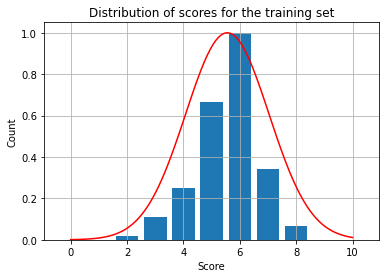

In [13]:
y_best = y[np.argmax(y)];
X_best = X[np.argmax(y)];

print('Found solution:')
params = [np.round(denorm_param(X_best[0], min_delta, max_delta)), \
          np.round(denorm_param(X_best[1], min_xcorr_int, max_xcorr_int)), \
          denorm_param(X_best[2], min_mpp, max_mpp)]
print('Params: ', params)
print('Score: ', y_best)

bins = np.asarray([i for i in range(max_h_score+1)])

data = xcorr_res_hist / np.max(xcorr_res_hist)
mean = np.sum(xcorr_res_hist * bins) / np.sum(xcorr_res_hist)
mu = mean / max_h_score
sigma = np.fmin(np.abs((max_h_score) - mean), np.abs(mean - 0)) / (3*(max_h_score))

pdf = scipy.stats.norm.pdf(np.linspace(0, 1, 100), mu, sigma)
pdf = pdf / np.max(pdf)

plt.bar(bins, data)
plt.plot(np.linspace(0, max_h_score, 100), pdf, color='r')
plt.grid()
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of scores for the training set')
plt.show()

This is a comparison of how the model performs using the initial and the optimised parameter set, on the training data set.
The parameters which are used as the baseline for comparison have been found earlier through manual tuning.

Baseline y:  [0.57456446]
Optimised y:  [0.58292683]
mu:  0.5571428571428572  sigma:  0.14761904761904762


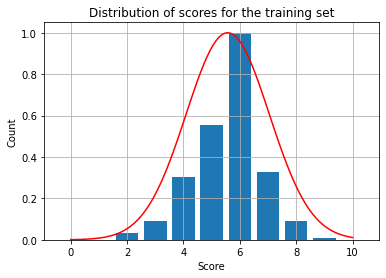

In [14]:
delta = 2;
xcorr_int = 32;
mpp = 0.15;

input_dir = 'data';

params = [delta, xcorr_int, mpp];
np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');    

with open('dataset.txt', 'wt') as f:
    f.write(input_dir)

run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);

xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
y = np.asarray([xcorr_res_avg]);
print('Baseline y: ', y)

params = [np.round(denorm_param(X_best[0], min_delta, max_delta)), \
          np.round(denorm_param(X_best[1], min_xcorr_int, max_xcorr_int)), \
          denorm_param(X_best[2], min_mpp, max_mpp)]

np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');

run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);

xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
y = np.asarray([xcorr_res_avg]);

print('Optimised y: ', y)

bins = np.asarray([i for i in range(max_h_score+1)])
data = xcorr_res_hist / np.max(xcorr_res_hist)

mean = np.sum(xcorr_res_hist * bins) / np.sum(xcorr_res_hist)
mu = mean / max_h_score
sigma = np.fmin(np.abs((max_h_score) - mean), np.abs(mean - 0)) / (3*(max_h_score))

print('mu: ', mu, ' sigma: ', sigma)

pdf = scipy.stats.norm.pdf(np.linspace(0, 1, 100), mu, sigma)
pdf = pdf / np.max(pdf)

plt.bar(bins, data)
plt.plot(np.linspace(0, max_h_score, 100), pdf, color='r')
plt.grid()
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of scores for the training set')
plt.show()

This is a comparison of how the model performs using the initial and the optimised parameter set, on the training validation set.
The optimised parameter set increases the algorithm accuracy for both the test and the validation data set.

Baseline y:  [0.65569935]
Optimised y:  [0.68317571]
mu:  0.6569437531110005  sigma:  0.11435208229633317


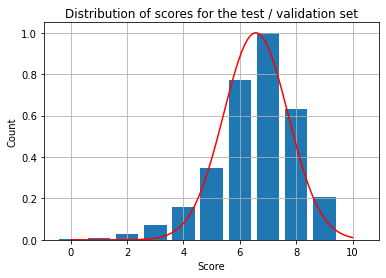

In [15]:
delta = 2;
xcorr_int = 32;
mpp = 0.15;

input_dir = 'data2';

params = [delta, xcorr_int, mpp];
np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');    

with open('dataset.txt', 'wt') as f:
    f.write(input_dir)

run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);

xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
y = np.asarray([xcorr_res_avg]);
print('Baseline y: ', y)

params = [np.round(denorm_param(X_best[0], min_delta, max_delta)), \
          np.round(denorm_param(X_best[1], min_xcorr_int, max_xcorr_int)), \
          denorm_param(X_best[2], min_mpp, max_mpp)]

np.savetxt('params.txt', np.asarray(params), fmt='%.2f', newline=' ', delimiter='');

run_model_py(input_dir, int(params[0]), int(params[1]), params[2]);

xcorr_res_hist, xcorr_res_avg = calc_score(input_dir)
y = np.asarray([xcorr_res_avg]);
print('Optimised y: ', y)

bins = np.asarray([i for i in range(max_h_score+1)])
data = xcorr_res_hist / np.max(xcorr_res_hist)

mean = np.sum(xcorr_res_hist * bins) / np.sum(xcorr_res_hist)
mu = mean / max_h_score
sigma = np.fmin(np.abs((max_h_score) - mean), np.abs(mean - 0)) / (3*(max_h_score))

print('mu: ', mu, ' sigma: ', sigma)

pdf = scipy.stats.norm.pdf(np.linspace(0, 1, 100), mu, sigma)
pdf = pdf / np.max(pdf)

plt.bar(bins, data)
plt.plot(np.linspace(0, max_h_score, 100), pdf, color='r')
plt.grid()
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of scores for the test / validation set')
plt.show()